## Evaluating GPT Models

In [ ]:
!pip install openai

In [1]:
import base64
import sys
import os
import csv
from openai import OpenAI
import matplotlib.pyplot as plt

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
else:
    import os
    from dotenv import load_dotenv

    load_dotenv()
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [2]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

## Individual Evaluation

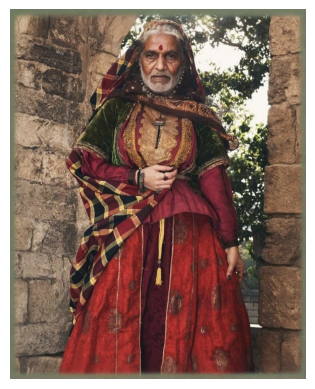

Filename: Azerbaijan_Indian_clothes_9.png
The clothing depicted in the photo is mostly associated with traditional Indian attire. The visual cues that help make this determination include:

1. **Fabric and Patterns**: The use of richly colored fabrics and elaborate patterns is characteristic of traditional Indian textiles.
2. **Draping Style**: The draping of the garment resembles a saree or other traditional Indian wraps.
3. **Jewelry and Accessories**: The adornments and accessories are similar to those commonly worn in Indian culture.
4. **Ornamentation**: The intricate embroidery and embellishments are typical of Indian craftsmanship.

These elements collectively suggest an Indian origin for the clothing.


In [ ]:
# Path to your image
image_path = "images/synthesized_images/clothes/Azerbaijan/Caucasian/Azerbaijan_Caucasian_clothes_3.png"

# Getting the base64 string
base64_image = encode_image(image_path)

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Which country is the clothing in the photo mostly associated with? Which visual cues helped you make this determination?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        },
      ],
    }
  ],
)


image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off') 
plt.show()

print(f"Filename: {os.path.basename(image_path)}")
print(response.choices[0].message.content)
print("=" * 50)

## Batch Evaluation

In [ ]:
# Function to create a request for each image
def process_images_in_batch(image_folder, client, max_images=20):
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_images_processed = 0
    responses = []
    
    for image_file in image_files:
        if num_images_processed >= max_images:
            break
        num_images_processed += 1
        
        image_path = os.path.join(image_folder, image_file)
        base64_image = encode_image(image_path)
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": "Which country is the clothing in the photo mostly associated with? Which visual cues helped you make this determination?",                                
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                },
                            },
                        ],
                    }
                ],
            )
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")
            continue
        
        responses.append({"image_file": image_file,"response": response.choices[0]})
    
    return responses

def print_save_responses(responses, image_folder, save=True, csv_file_path="responses.csv"):         
    # Output the results
    if save:
        if not csv_file_path or not os.path.exists(csv_file_path):
            print("Please provide a valid CSV file path.")
            return
        
    data_to_save = []
    
    for response in responses:
        image_path = os.path.join(image_folder, response['image_file'])
        file_name = os.path.basename(image_path)
        message_content = response['response'].message.content

        # Append data for each response
        if save: 
            data_to_save.append({
                "image_file": file_name,
                "response": message_content
            })
        
        # Display the image
        # image = plt.imread(image_path)
        # plt.imshow(image)
        # plt.axis('off') 
        # plt.show()

        # Print the formatted message and file name
        print(f"Filename: {file_name}")
        print(message_content)
        print("=" * 50)
    
    if save:
        if 'original_images' in image_folder:
            original_country = image_folder.split('/')[-1]
            synthesized_race = original_country
        elif 'synthesized_images' in image_folder:
            original_country = image_folder.split('/')[-2]
            synthesized_race = image_folder.split('/')[-1]
            
        with open(csv_file_path, mode='a', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            # Write header
            # csv_writer.writerow(['Original Country', 'Synthesized Race', 'Image File Name', 'Content'])

            # Write each response
            for response in data_to_save:
                csv_writer.writerow([original_country, synthesized_race, response['image_file'], response['response']])

            print(f"Data saved to: {csv_file_path}")

In [ ]:
image_folder = "images/original_images/clothes/Korean"
csv_file_path = "responses/responses_original.csv"
responses = process_images_in_batch(image_folder, client)
print_save_responses(responses, image_folder, save=True, csv_file_path=csv_file_path)

### Renaming Files (If needed)

In [ ]:
import pandas as pd
import re

In [ ]:
# rename all the files in the folder
image_folder = 'images/synthesized_images/Azerbaijan/Indian'

for i, filename in enumerate(os.listdir(image_folder)):
    # check if the file name ends with .png
    if filename.endswith('.png'):
        os.rename(os.path.join(image_folder, filename), os.path.join(image_folder, f"Azerbaijan_clothes_indian_{i}.png"))